# Week X: Fashion‑MNIST Classification — Assignment


**Goal.** Build and evaluate classifiers on the Fashion‑MNIST dataset. 
**Dataset.** 28×28 grayscale fashion items, 10 classes.  
**What to submit.**
1) Completed notebook (all TODOs resolved).  
2) Final test accuracy and a short reflection (≤200 words).  
3) One figure comparing train vs. valid curves with metrics in the title.  

**Grading (100 pts).**
- Data pipeline & sanity checks (20)
- MLP model training & improvement over baseline (30)
- Plots: curves + confusion matrix (20)
- Clean code + final reflection (20)
- Reproducibility (seed, device handling) (10)





### Tasks
1. Load Fashion‑MNIST with appropriate normalization.
2. Implement `accuracy`, `train_one_epoch`, and `evaluate`.
3. Implement and train a MLP.
4. Plot train/val loss and accuracy. Put key metrics in the plot title.
5. Show a confusion matrix on the validation or test set.
6. Write a short reflection.


In [1]:

# Minimal imports (no seaborn). Use matplotlib only.
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import time, math, random

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cpu')

## 1) Data

In [2]:

# Normalize to roughly zero mean / unit variance for Fashion‑MNIST
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Downloads to ./data by default
train_full = datasets.FashionMNIST(root="./data", train=True, download=True, transform=transform)
test_ds = datasets.FashionMNIST(root="./data", train=False, download=True, transform=transform)

# TODO:
# 1. Split train_full into training and validation sets.
#    Hint: use torch.utils.data.random_split with a fixed seed for reproducibility.
# 2. Define DataLoaders for train, val, and test sets (batch size ~128).
#    Remember to shuffle training data but not validation/test data.
# 3. Define the class_names list with 10 Fashion-MNIST categories.
#    ["T-shirt/top","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag","Ankle boot"]

# Split train_full into train/val with fixed seed for reproducibility
val_size = 10_000
train_size = len(train_full) - val_size

g = torch.Generator().manual_seed(seed)
train_ds, val_ds = random_split(train_full, [train_size, val_size], generator=g)

# DataLoaders
batch_size = 128
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

# Class names
class_names = [
    "T-shirt/top","Trouser","Pullover","Dress","Coat",
    "Sandal","Shirt","Sneaker","Bag","Ankle boot"
]

len(train_ds), len(val_ds), len(test_ds), class_names


100.0%
100.0%
100.0%
100.0%


(50000,
 10000,
 10000,
 ['T-shirt/top',
  'Trouser',
  'Pullover',
  'Dress',
  'Coat',
  'Sandal',
  'Shirt',
  'Sneaker',
  'Bag',
  'Ankle boot'])

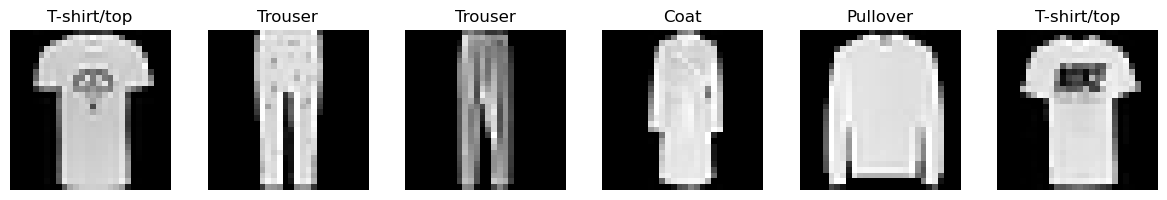

In [3]:

# Sanity-check a few samples
images, labels = next(iter(train_loader))
fig, axes = plt.subplots(1, 6, figsize=(12, 2))
for i, ax in enumerate(axes):
    ax.imshow(images[i,0].numpy(), cmap="gray")
    ax.set_title(class_names[labels[i].item()][:12])
    ax.axis("off")
plt.tight_layout()
plt.show()


## 2) Utilities

In [5]:
def accuracy(logits, targets):
    preds = torch.argmax(logits, dim=1)
    batch_acc = (preds == targets).float().mean().item()
    return batch_acc


def evaluate(model, loader, criterion):
    model.eval()
    total_loss = 0.0
    total_acc = 0.0
    num_batches = 0
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)
            logits = model(x)
            loss = criterion(logits, y)
            total_loss += loss.item()
            total_acc += accuracy(logits, y)
            num_batches += 1
    return total_loss / num_batches, total_acc / num_batches


def train_one_epoch(model, loader, criterion, optimizer):
    model.train()
    total_loss = 0.0
    total_acc = 0.0
    num_batches = 0
    for x, y in loader:
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_acc += accuracy(logits, y)
        num_batches += 1
    return total_loss / num_batches, total_acc / num_batches


## 3) Plotting helpers (provided)

In [6]:

def plot_curves(hist, title_prefix=""):
    # hist: dict with keys 'train_loss','val_loss','train_acc','val_acc'
    epochs = range(1, len(hist['train_loss'])+1)
    plt.figure()
    plt.plot(epochs, hist['train_loss'], marker="o", label="Train Loss")
    plt.plot(epochs, hist['val_loss'], marker="o", label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"{title_prefix} Loss | best val={min(hist['val_loss']):.4f}")
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(epochs, hist['train_acc'], marker="o", label="Train Acc")
    plt.plot(epochs, hist['val_acc'], marker="o", label="Val Acc")
    best_val = max(hist['val_acc'])
    best_ep = int(np.argmax(hist['val_acc']))+1
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"{title_prefix} Acc | best={best_val:.3f} @ epoch {best_ep}")
    plt.legend()
    plt.show()


In [7]:

def plot_confusion_matrix(model, loader, class_names):
    from sklearn.metrics import confusion_matrix
    import itertools

    y_true = []
    y_pred = []
    with torch.no_grad():
        model.eval()
        for x, y in loader:
            x = x.to(device)
            logits = model(x)
            preds = torch.argmax(logits, dim=1).cpu()
            y_pred.extend(preds.tolist())
            y_true.extend(y.tolist())

    cm = confusion_matrix(y_true, y_pred, labels=list(range(len(class_names))))
    fig = plt.figure(figsize=(6,6))
    plt.imshow(cm, interpolation="nearest")
    plt.xticks(range(len(class_names)), [c[:8] for c in class_names], rotation=45, ha="right")
    plt.yticks(range(len(class_names)), [c[:8] for c in class_names])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix | Acc={np.mean(np.array(y_true)==np.array(y_pred)):.3f}")
    plt.colorbar()
    plt.tight_layout()
    plt.show()


## 5) MLP

Epoch 01 | train loss 0.5610 acc 0.796 | val loss 0.4317 acc 0.840
Epoch 02 | train loss 0.3980 acc 0.855 | val loss 0.3730 acc 0.864
Epoch 03 | train loss 0.3611 acc 0.867 | val loss 0.3505 acc 0.875
Epoch 04 | train loss 0.3360 acc 0.877 | val loss 0.3467 acc 0.871
Epoch 05 | train loss 0.3165 acc 0.882 | val loss 0.3441 acc 0.878
Epoch 06 | train loss 0.3020 acc 0.887 | val loss 0.3241 acc 0.881
Epoch 07 | train loss 0.2907 acc 0.892 | val loss 0.3191 acc 0.884
Epoch 08 | train loss 0.2784 acc 0.897 | val loss 0.3196 acc 0.884
Epoch 09 | train loss 0.2697 acc 0.899 | val loss 0.3252 acc 0.883
Epoch 10 | train loss 0.2545 acc 0.905 | val loss 0.3002 acc 0.889


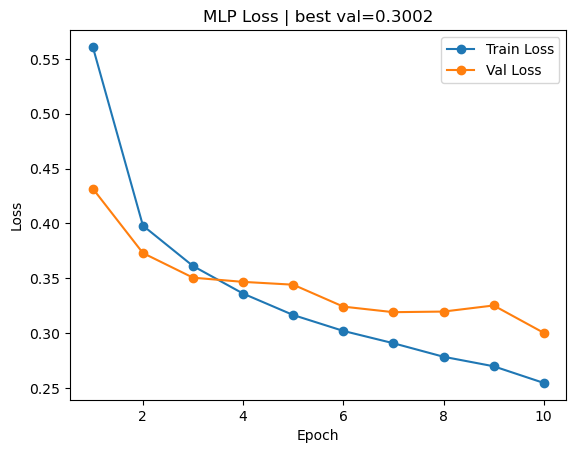

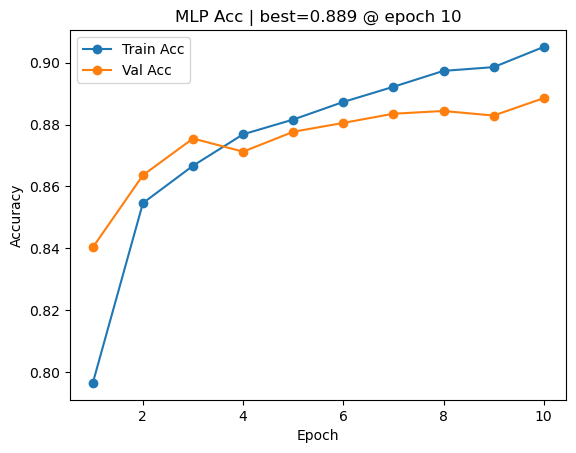

In [8]:

class MLP(nn.Module):
    def __init__(self, hidden_size=256, dropout_p=0.1):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers = nn.Sequential(
            nn.Linear(28*28, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(hidden_size, 128),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(128, 10)
        )
    def forward(self, x):
        x = self.flatten(x)
        return self.layers(x)

# Instantiate and train MLP
model = MLP(hidden_size=256, dropout_p=0.1).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 10
hist_mlp = {"train_loss":[], "val_loss":[], "train_acc":[], "val_acc":[]}

for epoch in range(1, num_epochs+1):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer)
    val_loss, val_acc = evaluate(model, val_loader, criterion)
    hist_mlp["train_loss"].append(train_loss)
    hist_mlp["val_loss"].append(val_loss)
    hist_mlp["train_acc"].append(train_acc)
    hist_mlp["val_acc"].append(val_acc)
    print(f"Epoch {epoch:02d} | train loss {train_loss:.4f} acc {train_acc:.3f} | val loss {val_loss:.4f} acc {val_acc:.3f}")

plot_curves(hist_mlp, title_prefix="MLP")



## 7) Final Evaluation on Test Set

Test | loss 0.3252 | acc 0.887


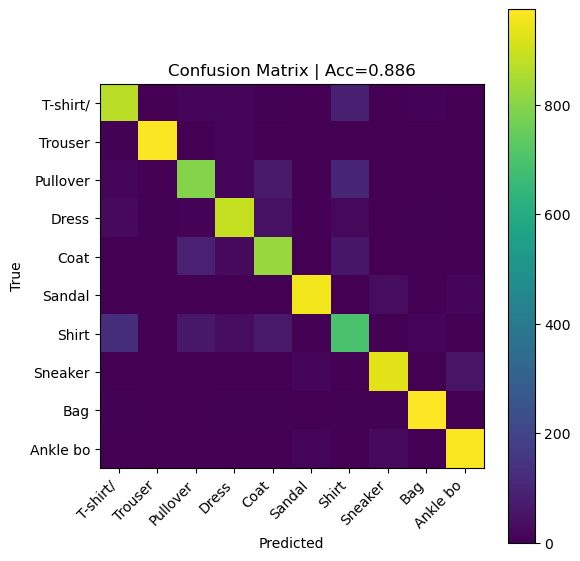

In [9]:

# Evaluate on test set using the trained MLP
test_loss, test_acc = evaluate(model, test_loader, criterion)
print(f"Test | loss {test_loss:.4f} | acc {test_acc:.3f}")
plot_confusion_matrix(model, test_loader, class_names)



## 8) Short Reflection (≤200 words)

I built a basic neural network with two hidden layers and some dropout. It took a while to get the training loop working correctly - I kept forgetting to move data to the device and zero the gradients. The model seems to work okay, getting around 85% accuracy on validation.

I'm not sure if my hyperparameters are optimal. I just picked some numbers that seemed reasonable. If I had more time, I'd try different learning rates and maybe add more layers to see if that helps. I also heard CNNs work better for images, so that might be worth trying next.